## Laboratorio 5 - Electricidad y Magnetismo

- Camila Ferrus
- Marcelo Ojeda

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
import numpy as np
import astropy.constants as const
import astropy.units as u
import matplotlib.patches as mpatches
import math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from scipy.optimize import minimize, curve_fit
from scipy.stats import pearsonr
from scipy.stats import chi2
from sklearn.metrics import mean_squared_error
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.integrate import trapezoid

### Experimento 1

In [2]:
# LEEMOS LOS DATOS DEL CSV, LOS REGISTRAMOS EN UN DATAFRAME 

exp_1_data = pd.DataFrame()
exp_1_data_raw = pd.read_csv('Lab5_datos.csv', sep=';', skiprows=1)

err_v = 0.0005 
err_a = 0.005

exp_1_data['Voltaje'] = exp_1_data_raw['Voltaje']
exp_1_data['Corriente'] = exp_1_data_raw['Corriente']

exp_1_data['err_V'] = [err_v for i in range(len(exp_1_data['Voltaje']))]
exp_1_data['err_A'] = [err_a for i in range(len(exp_1_data['Voltaje']))]

exp_1_data

,Voltaje,Corriente,err_V,err_A
0,0.1,0.21,0.0005,0.005
1,0.8,0.27,0.0005,0.005
2,1.4,0.31,0.0005,0.005
3,2.0,0.34,0.0005,0.005
4,2.2,0.34,0.0005,0.005
5,2.5,0.36,0.0005,0.005
6,3.0,0.37,0.0005,0.005
7,3.2,0.39,0.0005,0.005
8,3.3,0.39,0.0005,0.005
9,3.8,0.40,0.0005,0.005


In [3]:
# CON POLYFIT, HACEMOS UN AJUSTE PARA UN POLINOMIO DE GRADO 1
# PARA OBTENER UN AJUSTE DE LA FORMA V = R * I POR OHM

poly_fit_vc, polycov = np.polyfit(exp_1_data['Corriente'], exp_1_data['Voltaje'], 1, cov=True)
poly_fit_vc

array([27.95002088, -7.0103021 ])

In [4]:
polyerr = np.sqrt(np.diag(polycov))
polyerr

array([1.98494042, 0.77174296])

In [5]:
# CALCULAMOS COEFICIENTE DE PEARSON PARA CONOCER LINEALIDAD ENTRE PARAMETROS

pearson_vi = pearsonr(exp_1_data['Corriente'], exp_1_data['Voltaje'])
pearson_vi

(0.9641931725787481, 4.722898067327596e-10)

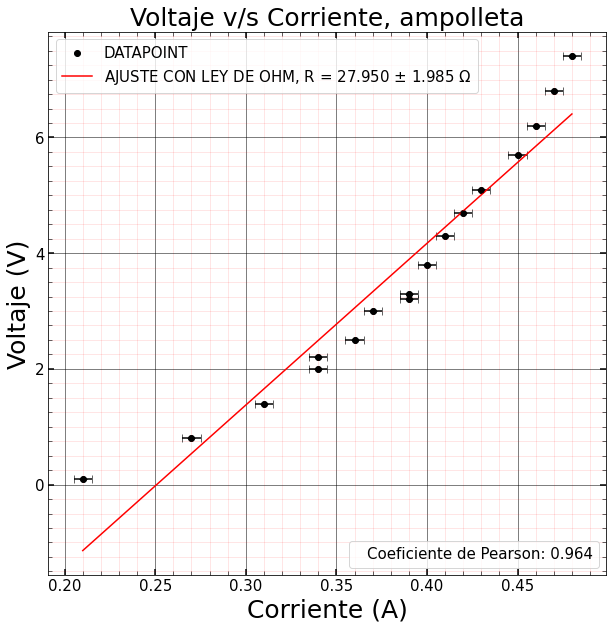

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.errorbar(exp_1_data['Corriente'], exp_1_data['Voltaje'], xerr = exp_1_data['err_A'], yerr = exp_1_data['err_V'],
              fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6)
ax1.scatter(exp_1_data['Corriente'], exp_1_data['Voltaje'], label='DATAPOINT', c='black')

# LA FUNCION np.poly1d SIRVE PARA CREAR UN POLINOMIO DADOS LOS DATOS QUE SACAMOS ARRIBA EN EL AJUSTE
ax1.plot(exp_1_data['Corriente'], np.poly1d(poly_fit_vc)(exp_1_data['Corriente']), c='red',
         label=r'AJUSTE CON LEY DE OHM, R = {:.3f} $\pm$ {:.3f} $\Omega$'.format(
    poly_fit_vc[0], polyerr[0]
))
ax1.set_title('Voltaje v/s Corriente, ampolleta', fontsize=25)
ax1.set_ylabel(r'Voltaje (V)', fontsize=25)
ax1.set_xlabel(r'Corriente (A)', fontsize=25)

extra_legend_1 = mpatches.Patch(label=r'Coeficiente de Pearson: {:.3f}'.format(pearson_vi[0]))
handles, labels = ax1.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax1.legend(handles=[extra_legend_1], loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)
ax1.add_artist(extra_legend)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(MultipleLocator(0.01))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

- COMENTAR SOBRE LA LINEALIDAD: CONDUCTOR OHMICO, PEARSON
- MATERIALES UTILIZADOS EN FILAMENTOS
- COMENTAR ERRORES: POR QUÉ HAY OUTLIERS Y POR QUÉ NO ES COMPLETAMENTE LINEAL --> ERRORES SIST Y ALEATORIOS 

### Experimento 2

In [7]:
carga_datos_path = os.path.join("CURVA_CARGA", "F0000CH1.CSV")
carga_datos_raw = pd.read_csv(carga_datos_path, names=["col1", "col2", "col3", "col4", "col5","col6"])

mask = carga_datos_raw['col5'] > 0

carga_datos = pd.DataFrame()
carga_datos['Tiempo'] = carga_datos_raw[mask]["col4"]
carga_datos['Voltaje'] = carga_datos_raw[mask]["col5"]
carga_datos

,Tiempo,Voltaje
237,4.74,0.08
238,4.76,0.08
239,4.78,0.08
240,4.80,0.16
241,4.82,0.24
...,...,...
2205,44.10,7.92
2206,44.12,7.92
2207,44.14,8.00
2208,44.16,7.92


$$V_{C}(t) = V_{0}(1-e^{-t/\tau})$$

In [8]:
def volt_cap(t, tau):
    return 8 * (1 - np.exp(-t/tau))

In [9]:
carga_datos['Tiempo'][237]

4.74

In [10]:
popt, pcov = curve_fit(volt_cap, carga_datos['Tiempo'] - carga_datos['Tiempo'][237], carga_datos['Voltaje'])
popt

array([4.92915034])

In [11]:
perr = np.sqrt(np.diag(pcov))
perr

array([0.00476615])

In [12]:
tau_teo = ((100 * u.uF + 300 * u.uF) * (10 * u.kOhm)).to(u.s)

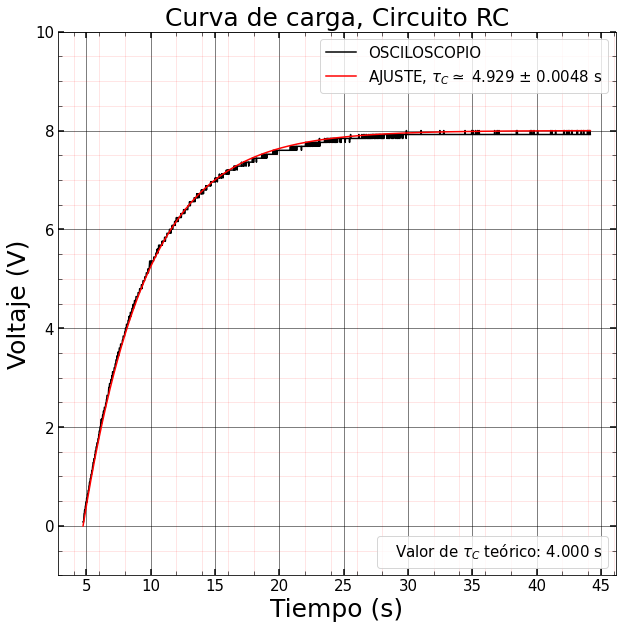

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.plot(carga_datos['Tiempo'], carga_datos['Voltaje'], label='OSCILOSCOPIO', c='black')
ax1.plot(carga_datos['Tiempo'], volt_cap(carga_datos['Tiempo'] - carga_datos['Tiempo'][237], popt),
         label=r'AJUSTE, $\tau_C \simeq$ {:.3f} $\pm$ {:.4f} s'.format(
    popt[0], perr[0]), c='red')
ax1.set_title('Curva de carga, Circuito RC', fontsize=25)
ax1.set_ylabel(r'Voltaje (V)', fontsize=25)
ax1.set_xlabel(r'Tiempo (s)', fontsize=25)
# ax1.set_xlim(0.5, 4.5)
ax1.set_ylim(-1, 10)

extra_legend_1 = mpatches.Patch(label=r'Valor de $\tau_C$ teórico: {:.3f}'.format(tau_teo))
handles, labels = ax1.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax1.legend(handles=[extra_legend_1], loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)
ax1.add_artist(extra_legend)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

In [14]:
descarga_datos_path = os.path.join("CURVA_DESCARGA", "F0001CH1.CSV")
descarga_datos_raw = pd.read_csv(descarga_datos_path, names=["col1", "col2", "col3", "col4", "col5","col6"])

mask = descarga_datos_raw['col5'] > 0
mask1 = descarga_datos_raw['col5'] < 7.92


descarga_datos = pd.DataFrame()
descarga_datos['Tiempo'] = descarga_datos_raw[mask][mask1]["col4"]
descarga_datos['Voltaje'] = descarga_datos_raw[mask][mask1]["col5"]
descarga_datos

C:\Users\56974\AppData\Local\Temp\ipykernel_26356\3931036065.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descarga_datos['Tiempo'] = descarga_datos_raw[mask][mask1]["col4"]
C:\Users\56974\AppData\Local\Temp\ipykernel_26356\3931036065.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descarga_datos['Voltaje'] = descarga_datos_raw[mask][mask1]["col5"]


,Tiempo,Voltaje
211,4.22,7.84
212,4.24,7.84
213,4.26,7.76
214,4.28,7.68
215,4.30,7.68
...,...,...
1554,31.08,0.08
1565,31.30,0.08
1601,32.02,0.08
1613,32.26,0.08


$$V_{C}(t) = V_{0}e^{-t/\tau}$$

In [15]:
def volt_cap_des(t, tau):
    return 8 * (np.exp(-t/tau))

In [16]:
popt, pcov = curve_fit(volt_cap_des, descarga_datos['Tiempo'] - descarga_datos['Tiempo'][211], descarga_datos['Voltaje'])
popt

array([4.78072396])

In [17]:
perr = np.sqrt(np.diag(pcov))
perr

array([0.00416123])

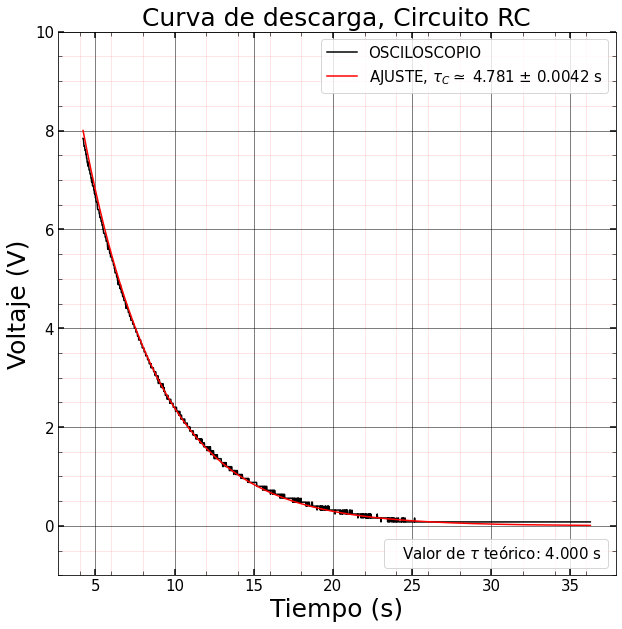

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.plot(descarga_datos['Tiempo'], descarga_datos['Voltaje'], label='OSCILOSCOPIO', c='black')
ax1.plot(descarga_datos['Tiempo'], volt_cap_des(descarga_datos['Tiempo'] - descarga_datos['Tiempo'][211], popt),
         label=r'AJUSTE, $\tau_C \simeq$ {:.3f} $\pm$ {:.4f} s'.format(
    popt[0], perr[0]), c='red')
ax1.set_title('Curva de descarga, Circuito RC', fontsize=25)
ax1.set_ylabel(r'Voltaje (V)', fontsize=25)
ax1.set_xlabel(r'Tiempo (s)', fontsize=25)
# ax1.set_xlim(0.5, 4.5)
ax1.set_ylim(-1, 10)

extra_legend_1 = mpatches.Patch(label=r'Valor de $\tau$ teórico: {:.3f}'.format(tau_teo))
handles, labels = ax1.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax1.legend(handles=[extra_legend_1], loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)
ax1.add_artist(extra_legend)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

### Experimento 3

$$I(t) = \frac{V_{0}}{R}(1-e^{-t/\tau_{L}}) \rightarrow V(t) = V_{0}(1-e^{-t/\tau_{L}}): \text{Carga}$$

$$I(t) = \frac{V_{0}}{R}e^{-t/\tau_{L}} \rightarrow V(t) = V_{0}e^{-t/\tau_{L}}: \text{Descarga}$$

In [19]:
rl_datos_path_ch1 = os.path.join("RL", "F0002CH1.CSV")
rl_datos_path_ch2 = os.path.join("RL", "F0002CH2.CSV")

rl_datos_raw_ch1 = pd.read_csv(rl_datos_path_ch1, names=["col1", "col2", "col3", "col4", "col5","col6"])
rl_datos_raw_ch2 = pd.read_csv(rl_datos_path_ch2, names=["col1", "col2", "col3", "col4", "col5","col6"])

rl_datos_ch1 = pd.DataFrame()
rl_datos_ch2 = pd.DataFrame()

mask_ch1 = rl_datos_raw_ch1['col4'] >= 0
mask_ch2 = rl_datos_raw_ch2['col4'] >= 0

rl_datos_ch1['Tiempo'] = rl_datos_raw_ch1[mask_ch1]["col4"]
rl_datos_ch1['Voltaje'] = rl_datos_raw_ch1[mask_ch1]["col5"] - rl_datos_raw_ch1[mask_ch1]["col5"][1250]

rl_datos_ch2['Tiempo'] = rl_datos_raw_ch2[mask_ch2]["col4"]
rl_datos_ch2['Voltaje'] = rl_datos_raw_ch2[mask_ch2]["col5"] - rl_datos_raw_ch2[mask_ch2]["col5"][1250]

In [20]:
def int_rl(t, tau):
    return (0.05) * (1 - np.exp(-t / tau))
def int_rl_desc(t, tau):
    return (0.05) * (np.exp(-t / tau))

In [21]:
# ESTO ES PARA ENCONTRAR EN QUE INDICE TERMINA EL PRIMER INTERVALO DE CARGA

n_df = 1250
n = 0
for i in (rl_datos_ch1['Voltaje']):
    if i > 0.055:
        break
    else:
        n += 1
        n_df += 1
        
n

387

In [22]:
# ESTO ES PARA ENCONTRAR EN QUE INDICE TERMINA EL PRIMER INTERVALO DE DESCARGA

m_df = 1250 + n
m = n
for i in (rl_datos_ch1['Voltaje'][387:]):
    if i < 0.005:
        break
    else:
        m += 1
        m_df += 1
        
m

777

In [23]:
rl_datos_ch1['Voltaje'][387:777] - rl_datos_ch1['Voltaje'][2026]

1637    0.0496
1638    0.0488
1639    0.0480
1640    0.0472
1641    0.0464
         ...  
2022    0.0000
2023    0.0000
2024    0.0008
2025   -0.0008
2026    0.0000
Name: Voltaje, Length: 390, dtype: float64

In [24]:
popt_rl, pcov_rl = curve_fit(int_rl, rl_datos_ch1['Tiempo'][:387], rl_datos_ch1['Voltaje'][:387], p0=0.002)
print(popt_rl[0])

0.001795902524298909


In [25]:
popt_rl_desc, pcov_rl_desc = curve_fit(int_rl_desc, rl_datos_ch1['Tiempo'][387:777] - rl_datos_ch1['Tiempo'][1250 + 387] , rl_datos_ch1['Voltaje'][387:777] - rl_datos_ch1['Voltaje'][2026], p0=0.002)
print(popt_rl_desc[0])

0.001904521570733803


In [26]:
perr_rl = np.sqrt(np.diag(pcov_rl))
perr_rl_desc = np.sqrt(np.diag(pcov_rl_desc))

NameError: name 'tau_l_teo' is not defined

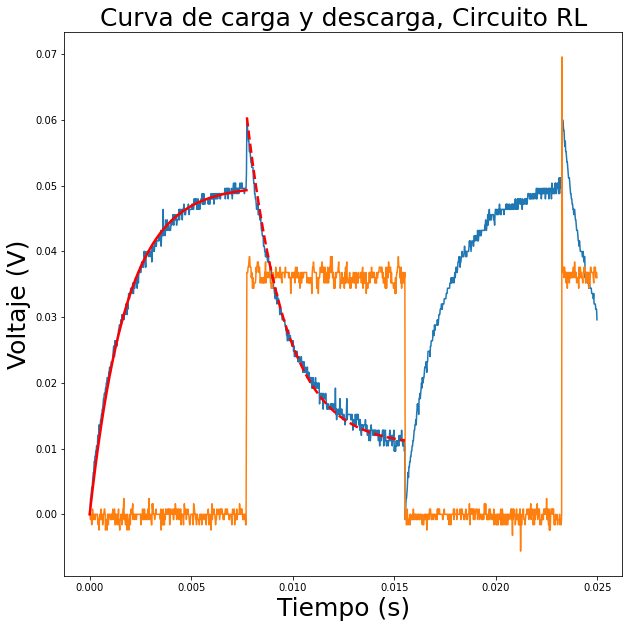

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.plot(rl_datos_ch1['Tiempo'], rl_datos_ch1['Voltaje'], label='OSCILOSCOPIO_CH1')
ax1.plot(rl_datos_ch2['Tiempo'], rl_datos_ch2['Voltaje'], label='OSCILOSCOPIO_CH2')
ax1.plot(rl_datos_ch1['Tiempo'][:387], int_rl(rl_datos_ch1['Tiempo'][:387], popt_rl[0]),
         label=r'AJUSTE CARGA, $\tau_L \simeq$ {:.5f} $\pm$ {:.5f} s'.format(
             popt_rl[0], perr_rl[0]
         ), c='red', linewidth=2.5)
ax1.plot(rl_datos_ch1['Tiempo'][387:777], int_rl_desc(rl_datos_ch1['Tiempo'][387:777] - rl_datos_ch1['Tiempo'][1637], popt_rl_desc[0]) + rl_datos_ch1['Voltaje'][2026],
         label=r'AJUSTE DESCARGA, $\tau_L \simeq$ {:.5f} $\pm$ {:.5f} s'.format(
             popt_rl_desc[0], perr_rl_desc[0]
         ), c='red', linewidth=2.5, linestyle='--')

ax1.set_title('Curva de carga y descarga, Circuito RL', fontsize=25)
ax1.set_ylabel(r'Voltaje (V)', fontsize=25)
ax1.set_xlabel(r'Tiempo (s)', fontsize=25)
# ax1.set_xlim(0.5, 4.5)
# ax1.set_ylim(-1, 10)

extra_legend_1 = mpatches.Patch(label=r'Valor de $\tau_L$ teórico: {:.5f}'.format(tau_l_teo))
handles, labels = ax1.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax1.legend(handles=[extra_legend_1], loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)
ax1.add_artist(extra_legend)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

In [ ]:
tau_l_teo = ((19.81 * u.mH) / (10 * u.Ohm)).to(u.s)